# Clustering (K-means & Hierarchique)

Imports et chargement des données

In [1]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# --- (re)charger la matrice PCA compacte ------------------
X_red = np.load("X_PCA80.npy")   # ou X_pca80 si déjà en mémoire


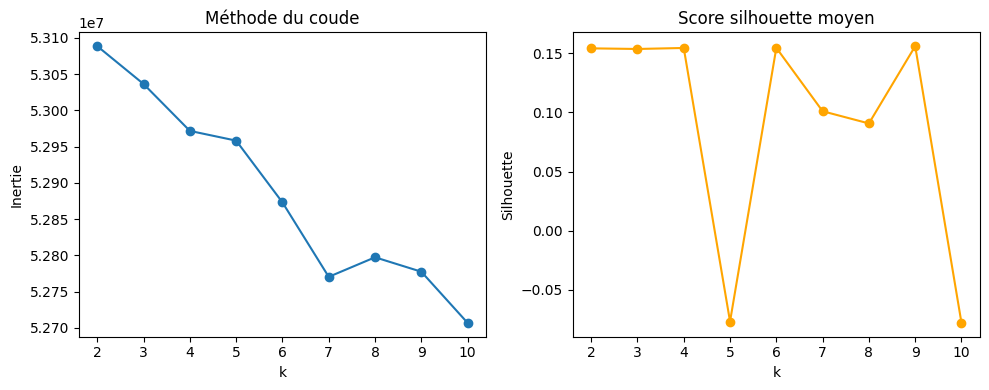

In [2]:
# ==========================================================
# 3.1 Choisir k pour K-means ─ courbe du coude & silhouette
# ==========================================================

Ks = range(2, 11)
inertias, silhs = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    labels = km.fit_predict(X_red)
    inertias.append(km.inertia_)
    silhs.append(silhouette_score(X_red, labels))

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Coude
ax[0].plot(Ks, inertias, marker="o")
ax[0].set_title("Méthode du coude")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertie")

# Silhouette
ax[1].plot(Ks, silhs, marker="o", color="orange")
ax[1].set_title("Score silhouette moyen")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")

plt.tight_layout(); plt.show()

# --- Choisissez k (ex. pic silhouette ou coude) -----------
k_opt = 6      # ⇐ ajustez après inspection des graphes


In [ ]:
# ==================================
# 3.2 K-means définitif et étiquettes
# ==================================
km_final = KMeans(n_clusters=k_opt, n_init=50, random_state=0)
FDS["cluster_km"] = km_final.fit_predict(X_red)

print(FDS["cluster_km"].value_counts().sort_index())


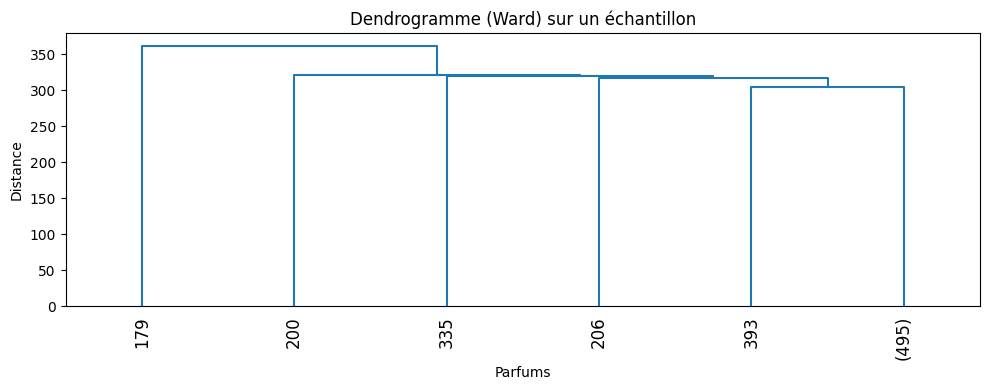

MemoryError: unable to allocate array data.

In [3]:
# ======================================================
# 3.3 Regroupement hiérarchique (Ward) + dendrogramme
# ======================================================
from scipy.cluster.hierarchy import linkage, dendrogram

# échantillonner 500 parfums pour lisibilité
idx_sample = np.random.choice(range(X_red.shape[0]), size=500, replace=False)
Z = linkage(X_red[idx_sample], method="ward")

plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=4, leaf_rotation=90)
plt.title("Dendrogramme (Ward) sur un échantillon")
plt.xlabel("Parfums"); plt.ylabel("Distance")
plt.tight_layout(); plt.show()

# Si vous voulez des labels hiérarchiques complets :
hc = AgglomerativeClustering(n_clusters=k_opt, linkage="ward")
FDS["cluster_hc"] = hc.fit_predict(X_red)


In [ ]:
# =============================================
# 3.4 Tableau descriptif des clusters K-means
# =============================================
import pandas as pd

def top_modalities(df, pattern, n=3):
    cols = [c for c in df.columns if c.startswith(pattern)]
    return (df[cols].sum()
            .sort_values(ascending=False)
            .head(n)
            .index.str.replace(pattern, "")
            .tolist())

desc = []

for c in sorted(FDS["cluster_km"].unique()):
    sub = FDS[FDS["cluster_km"] == c]
    accords = top_modalities(sub, "accord_", 5)
    row = {
        "Cluster":            c,
        "Taille":             len(sub),
        "Année_médiane":      sub["Launch_year"].median(),
        "Note_médiane":       sub["Rating_value"].median(),
        "Genres (%)":         sub["gender"].value_counts(normalize=True).head(3).round(2).to_dict(),
        "Top accords":        accords
    }
    desc.append(row)

table_desc = pd.DataFrame(desc).set_index("Cluster")
display(table_desc)


## Comment exploiter ces résultats

Sortie obtenue | Lecture & actions suivantes

Coude (inertie) | Repérez le point où la baisse d’inertie ralentit nettement : c’est un k plausible.

Silhouette | Cherchez k avec un score maximal ou au moins stable (> 0.25 considérée « correcte »).

Dendrogramme | Confirmez visuellement le nombre de grands groupes : coupez l’arbre à la distance qui isole ~k grappes.

Tableau descriptif | Pour chaque cluster :• Accord(s) dominant(s) → donne une signature olfactive.• Répartition genre → “cluster mixte”, “cluster masculin”…• Année médiane → vintage vs contemporain ?• Note médiane → performance qualitative.

Vous pouvez maintenant :

- Tracer un scatter PC1 × PC2 coloré par cluster_km pour visualiser les segments.

- Utiliser cluster_km comme variable explicative/stratification pour vos modèles supervisés.

- Discuter des stratégies de marque : « Le cluster 4 (floral musqué, unisex, années 2020) obtient les meilleures notes… »